<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
import re
from unidecode import unidecode
import random

# ------------------------------------------------------------------------- #
# Preprocess text to remove formulas and strange characters
def preprocess_text(text):
    # Rimuovi formule matematiche LaTeX
    text = re.sub(r'\$.*?\$', '', text)
    # Rimuovi caratteri non alfanumerici eccetto punteggiatura di base
    text = re.sub(r'[^a-zA-Z0-9\s.,;:!?\'"-]', '', text)
    # Rimuovi •
    text = text.replace('•', '')
    # Normalizza i caratteri Unicode
    text = unidecode(text)
    # Rimuovi spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def aggregate_short_documents(texts, min_length=50):
    aggregated_texts = []
    buffer = ""
    
    for doc in texts:
        if len(doc.page_content) < min_length:
            buffer += " " + doc.page_content
            buffer = buffer.strip()
        else:
            if buffer:
                doc.page_content = buffer + " " + doc.page_content
                buffer = ""
            aggregated_texts.append(doc)
    
    if buffer:
        if aggregated_texts:
            aggregated_texts[-1].page_content += " " + buffer
        else:
            aggregated_texts.append(buffer)
    
    return aggregated_texts

# ------------------------------------------------------------------------- #

PDF_NAME = "IR Slides v1.0.pdf"

# Load and process the PDF
loader = PyMuPDFLoader(PDF_NAME)
documents = loader.load()

# Split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separator="\n")
texts = text_splitter.split_documents(documents)

# Preprocess the text
for doc in texts:
    doc.page_content = preprocess_text(doc.page_content)

# Aggrega i documenti corti
corpus = aggregate_short_documents(texts)

In [2]:
# print some random pages with their indices
random.seed(42)
for i in range(5):
    doc = random.choice(corpus)
    doc_index = corpus.index(doc)
    print(f"DocId: {doc_index}, {doc.page_content[:100]}...")

DocId: 57, Ranked Retrieval In Boolean retrieval documents either match or dont a query Good for expert users w...
DocId: 12, cat command: reads files sequentially, writing them to the standard output tr command: copies the st...
DocId: 140, Given the sample space , the function is called probability. For each event , we denote as the proba...
DocId: 125, Example Assume relevant documents in total Assume an impatient user, i.e., RB 8 b 2 DCG10 3 1 log2 3...
DocId: 114, Rank-based Metrics Precision at document cutoff : where is the relevance judgment of the -th retriev...


In [3]:
print(f"Average document length: {sum(len(doc.page_content) for doc in corpus) / len(corpus)}")

Average document length: 464.3265993265993


In [4]:
import os

def save_documents(documents):
    if not os.path.exists("vector_store"):
        os.makedirs("vector_store")
    # delete all files in the vector_store directory
    for file in os.listdir("vector_store"):
        os.remove(os.path.join("vector_store", file))
    for i, doc in enumerate(documents):
        with open(f"vector_store/document_{i}.txt", "w", encoding="utf-8") as f:
            f.write(doc.page_content)

save_documents(corpus)

In [5]:
print(f"Saved {len(corpus)} documents in the vector_store directory.")

Saved 297 documents in the vector_store directory.


In [6]:
import json

def extract_questions(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    questions = []
    for item in data:
        # q = item.get("question", "")
        # a = item.get("answers", "")
        # # 'a' è una lista di stringhe, aggiungi ad ognuno 1, 2, 3, 4
        # for i in range(len(a)):
        #     a[i] = f"{(1 + i)}) {a[i]}"
        # a = " ".join(a)
        # qplusa = f"{q} {a}"
        if str(item.get("category", "")) == "1":
            continue
        question = {
            "question": item.get("question", "").strip(),
            # "answers": item.get("answers", ""),
            # "correct": item.get("correct", ""),
            # "category": item.get("category", ""),
            # "question_id": item.get("question_id", "")
        }
        questions.append(question)
    return questions


queries = extract_questions('quiz/quiz.json')
print(f"Loaded {len(queries)} questions.")

random.seed(4242)
print(random.choice(queries))

Loaded 60 questions.
{'question': 'Which of the following metrics is used to measure overlap between two sets?'}


# 1. Gather dataset embeddings
- CDE works by first getting a set of embeddings from corpus documents that is intended to be representative of the overall corpus. We first sample a number of documents from the corpus (this model is trained with 512 documents from each context) and get their embeddings from our first-stage model.
- Now that we have obtained "dataset embeddings" we can embed documents and queries like normal. Remember to use the document prompt for documents:

model card : https://huggingface.co/jxm/cde-small-v1

In [7]:
from sentence_transformers import SentenceTransformer

# with sentence-transformers we don't need prefixes but, to do retrieval, we need to use prompt_name="query" and prompt_name="document" in the encode method of the model when embedding queries and documents, respectively.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model
model = SentenceTransformer("jxm/cde-small-v1", trust_remote_code=True).to(device)

Using device: cuda


C:\Users\giuli\.cache\huggingface\modules\transformers_modules\nomic-ai\nomic-bert-2048\eb02ceb48c1fdcc477ff1925c9732c379f0f0d1f\modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

Disabled 37 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.BiEncoder'>
modified 12 rotary modules – set rotary_start_pos to 512
Disabled 74 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.DatasetTransformer'>


In [8]:
minicorpus_size = model[0].config.transductive_corpus_size # 512
minicorpus_docs = random.choices(corpus, k=minicorpus_size) # oversampling is okay
assert len(minicorpus_docs) == minicorpus_size # You must use exactly this many documents in the minicorpus. You can oversample if your corpus is smaller.

dataset_embeddings = model.encode(
    [doc.page_content for doc in minicorpus_docs],
    prompt_name="document",
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Corpus size: {len(corpus)}")
print(f"Computed embeddings for {len(minicorpus_docs)} documents. Shape: {dataset_embeddings.shape}")

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Corpus size: 297
Computed embeddings for 512 documents. Shape: torch.Size([512, 768])


In [9]:
print("Some mini-corpus documents:")

# get some random documents from the minicorpus
random.seed(4242)
for i in random.sample(range(minicorpus_size), 5):
    print(f"document {i}: {minicorpus_docs[i].page_content[:100]}...")

Some mini-corpus documents:
document 425: Term Distribution Also known as distributed global indexing Single index is built for the whole clus...
document 134: Link Analysis Link-based ranking: use hyperlinks to rank web documents Use link counts as simple mea...
document 29: Cascading Query Index Processing 1,000 10,000 docs Base Ranker Inverted Index First Stage Top Ranker...
document 399: Multimedia Information Retrieval and Computer Vision nicola.tonellottounipi.it...
document 388: description lang"so"Hel wargelinada sunta cayayaanka ee cuntada ilmaha.description description lang"...


# 2. Get doc embeddings

In [10]:
doc_embeddings = model.encode(
    [doc.page_content for doc in corpus],
    prompt_name="document",
    dataset_embeddings=dataset_embeddings, # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

query_embeddings = model.encode(
    [query['question'] for query in queries],
    prompt_name="query",
    dataset_embeddings=dataset_embeddings,  # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Document embeddings shape: {doc_embeddings.shape}")
print(f"Query embeddings shape: {query_embeddings.shape}")

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Document embeddings shape: torch.Size([297, 768])
Query embeddings shape: torch.Size([60, 768])


In [21]:
similarities = model.similarity(query_embeddings, doc_embeddings)
print("'similarities' shape : ",similarities.shape)
topk_values, topk_indices = similarities.topk(5)

random.seed(4242)
random_queries = random.sample(queries, 2)
for query in random_queries:
    query_idx = queries.index(query)
    print(f"Query: {query['question']}")
    for j, idx in enumerate(topk_indices[query_idx]):
        doc = corpus[idx]
        print(f"Rank {j+1} (Score: {topk_values[query_idx][j]:.4f}, Doc ID: {idx}): {doc.page_content[:200]}...")
    print()


'similarities' shape :  torch.Size([60, 297])
Query: Which of the following metrics is used to measure overlap between two sets?
Rank 1 (Score: 0.6110, Doc ID: 73): Jaccard Coefficient A common measure of overlap of two finite sets and : Always assigns a number between 0 and 1 and do not have to be the same size Note that and if What is the query-document match s...
Rank 2 (Score: 0.5788, Doc ID: 135): The -test assumes that the evaluation data is measure on an interval scale Differences between values are significant Effectiveness measures are an ordinal scale Differences between values are not sig...
Rank 3 (Score: 0.5662, Doc ID: 288): AB Testing Concept is fairly trivial: randomly split traffic between two or more versions A Control B Treatment Collect metrics of interest analyse Run statistical tests to confirm differences are not...
Rank 4 (Score: 0.5491, Doc ID: 113): Precision and recall are two different numbers to evaluate the effectiveness of an IR system Can we coalesce the

# 3. Chroma

In [12]:
from chromadb import Client, Collection

# Initialize the Chroma client
client = Client()

COLLECTION_NAME = "chroma-collection"

# Check if the collection exists and delete it if it does
if COLLECTION_NAME in [col.name for col in client.list_collections()]:
    client.delete_collection(name=COLLECTION_NAME)
    print(f"Collection {COLLECTION_NAME} exists, deleting it")
else:
    print(f"Collection {COLLECTION_NAME} does not exist")

Collection chroma-collection does not exist


In [13]:
from chromadb import Documents, EmbeddingFunction, Embeddings

class CustomEmbeddingFunction(EmbeddingFunction):
    def __init__(self, mode="document"):
        self.mode = mode  # "document" or "query"
        
    def __call__(self, input: Documents) -> Embeddings:

        # se input è una lista di documenti, estrai il testo
        if isinstance(input, list):
            input = [doc if isinstance(doc, str) else doc.page_content for doc in input]
        
        # Genera embeddings usando il modello specifico
        embeddings = model.encode(
            input,
            prompt_name=self.mode,
            dataset_embeddings=dataset_embeddings,
            convert_to_tensor=True,
            show_progress_bar=True
        ).cpu().numpy()
        
        return embeddings.tolist()

# Create an instance of your embedding function
doc_embedding_function = CustomEmbeddingFunction(mode="document")

# Create a Chroma collection with the custom embedding function
collection: Collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=doc_embedding_function,
    get_or_create=True,
    metadata={"hnsw:space": "cosine"} # l2 is the default but cosine is more suitable for this embedding function
)

# Add the documents to the collection
collection.add(
    ids=[str(i) for i in range(len(corpus))],  # Unique identifiers for the documents
    embeddings=doc_embeddings.cpu().numpy(),
    documents=[doc.page_content for doc in corpus],
)

In [14]:
#print(collection.peek()) # returns a list of the first 10 items in the collection
print(collection.count()) # returns the number of items in the collection

297


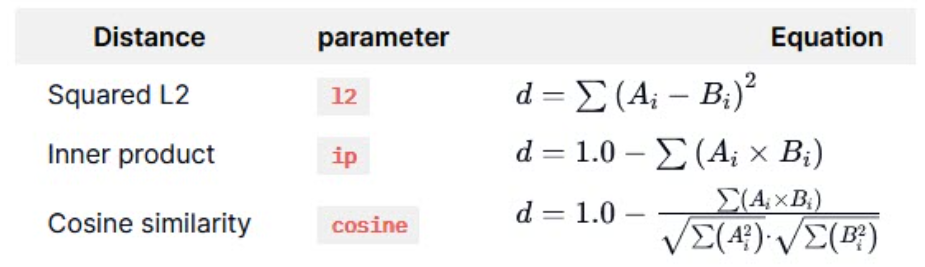

In [39]:
query_text = "How many bytes can UTF-8 use to encode a character?"
query_embedding_function = CustomEmbeddingFunction(mode="query")
query_embeddings = query_embedding_function(query_text)

results = collection.query(
    query_embeddings=query_embeddings,
    n_results=5
)

# Print the results with the document IDs and scores
for i, (doc_id, score) in enumerate(zip(results['ids'][0], results['distances'][0])):
    print(f"Rank {i+1}: Document ID: {doc_id}, Score: {1-score:.4f}, {corpus[int(doc_id)].page_content[:200]}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Rank 1: Document ID: 4, Score: 0.6931, All Unicode characters larger than U007F are encoded as a sequence of two or more bytes, each of which has the most significant bit set This means that no ASCII byte can appear as part of any other ch
Rank 2: Document ID: 3, Score: 0.6924, Unicode is not a character encoding scheme Unicode code points are just numeric values assigned to characters Code points are not representations of characters as sequences of bytes For example, the c
Rank 3: Document ID: 1, Score: 0.6807, Text Processing Encodings The ASCII encoding maps characters to 7-bit integers using the range from 0 to 127 to represent 94 printing characters, 33 control characters, and the space since a byte is u
Rank 4: Document ID: 6, Score: 0.6640, Convert U05E7 to UTF-8 Determine that it is in the interval 0080 to 07FF, requiring two bytes: The encoding has the form: 110xxxxx 10xxxxxx Write the code point in binary: 0000 0101 1110 0111 The righ
Rank 5: Document ID: 5, Score: 0.6164, T

# 3. Compute scores between queries and documents

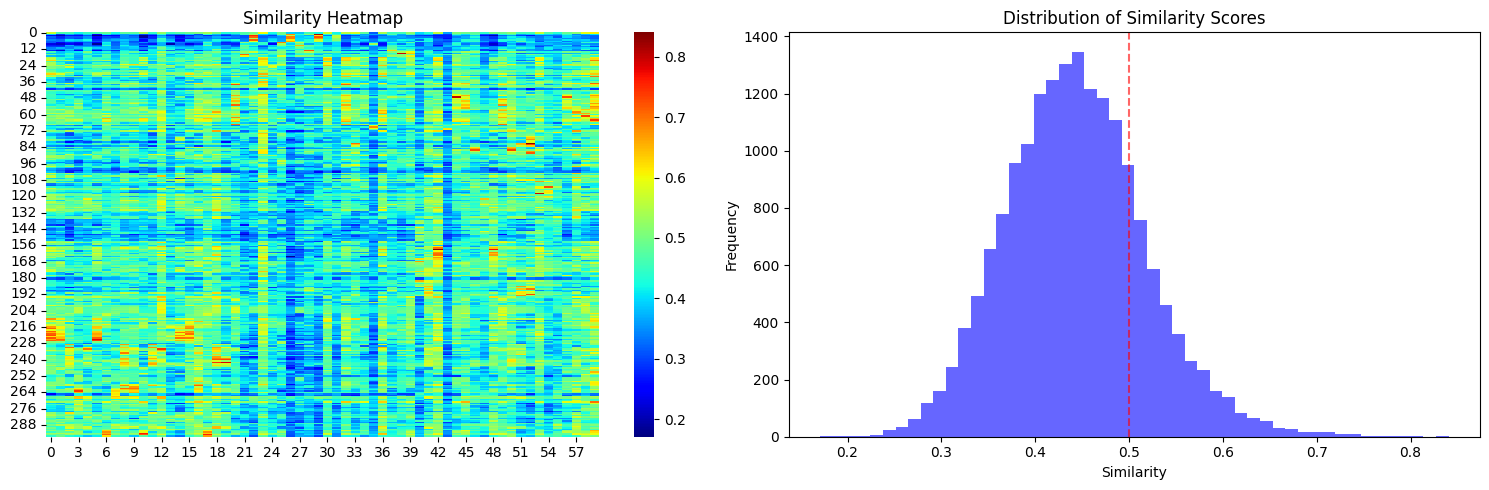

In [31]:
from seaborn import heatmap
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap
heatmap(similarities.cpu().numpy().T, cmap="jet", ax=axes[0])
axes[0].set_title("Similarity Heatmap")

# Plot histogram
axes[1].hist(similarities.cpu().flatten(), bins=50, color='blue', alpha=0.6)
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].axvline(x=0.5, color='red', alpha=0.6, linestyle='--')

plt.tight_layout()
plt.show()